In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Creation bases regresseurs

Pour étudier la mobilité résidentielle en France en 2018, nous nous basons sur quelques variables qui peuvent être déterminantes.  
Ce NoteBook vise à construire la base des régresseurs disponibles, dont :
- les équipements par département (ex. présence d'hypermarchés, de salles multisports,...)
- la position géographique des départements (litorraux et frontières européennes)
- le salaire moyen par département
- le taux de chômage moyen par département

In [58]:
# Récupération des donnees generiques sur les departements francais

df_dpt = pd.read_csv(r'.\departements-francais.csv',sep="\t")
df_dpt = df_dpt.drop(df_dpt.index[len(df_dpt)-1])
df_dpt = df_dpt.drop(df_dpt.index[len(df_dpt)-1])

# On retire les Outre-Mers

for dpt in [971,972,973,974,976]:
    df_dpt = df_dpt.drop(df_dpt.index[df_dpt['NUMÉRO'] == str(dpt)])

df_dpt.head()

,NUMÉRO,NOM,REGION,CHEF LIEU,SUPERFICIE (km²),POPULATION,DENSITE (habitants/km2)
0,1,Ain,Auvergne-Rhône-Alpes,Bourg-en-Bresse,5762.0,631877.0,109.7
1,2,Aisne,Hauts-de-France,Laon,7369.0,538659.0,73.1
2,3,Allier,Auvergne-Rhône-Alpes,Moulins,7340.0,341613.0,46.5
3,4,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur,Digne,6925.0,161799.0,23.4
4,5,Hautes-Alpes,Provence-Alpes-Côte d'Azur,Gap,5549.0,140916.0,25.4


In [59]:
# Définition de la base contenant les équipements par département en 2015
df_nbeq = pd.read_csv('.\Bpe1520_nb_equip_DEP.csv',sep = ';').drop(columns='NB_2020')

df_nbeq.head()

,DEP,TYPEQU,NB_2015
0,01,A101,2
1,01,A104,46
2,01,A105,0
3,01,A106,1
4,01,A107,4


Les différents type d'équipement sont codés   
ex. A104 = Gendarmerie : _"Unités de gendarmeries recevant du public. Ce type d’équipement comprend les brigades territoriales autonomes,les brigades territoriales de proximité, les brigades territoriales de contact et les communautés de brigades.
(source : OED-Min Défense)"_

Nous avons donc choisi de les regrouper selon les catégories suivantes:

In [60]:
# Aggrégation sur un nombre restreint de catégorie

## Definition des categories
categories = {'A10':'Justice',
                  'A203':'Banque',
                  'A30':'Automobile',
                  'A40':'Construction',
                  'B10':'Grande surface',
                  'B20':'Petite surface',
                  'B30':'Magasin de consommation',
                  'D':'Sante',
                  'E':'Transport',
                  'F':'Infrastructure sportive',
                  'G':'Tourisme'}

## Association de chaque categorie dans une nouvelle colonne
data_cat = pd.DataFrame()
for cat in categories:
    data = df_nbeq[df_nbeq['TYPEQU'].str.contains(cat)]
    data['Categorie'] = categories[cat]
    data_cat = pd.concat([data_cat, data])
 
data_cat.drop('TYPEQU', axis = 1, inplace = True)

data_cat.head()

<ipython-input-60-b90486a97069>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Categorie'] = categories[cat]


,DEP,NB_2015,Categorie
0,01,2,Justice
1,01,46,Justice
2,01,0,Justice
3,01,1,Justice
4,01,4,Justice


In [61]:
#Creation de la table agregee des donnees equipements par departement
df_equip = data_cat.groupby(["DEP", "Categorie"]).sum().pivot_table(values = 'NB_2015',columns="Categorie", index = 'DEP')

df_equip.head()

Categorie,Automobile,Banque,Construction,Grande surface,Infrastructure sportive,Justice,Magasin de consommation,Petite surface,Sante,Tourisme,Transport
DEP,,,,,,,,,,,
01,1216,295,4855,158,2181,57,1089,864,2788,385,276
02,770,176,3192,161,1928,57,864,693,2297,196,204
03,591,191,2343,108,1153,45,850,654,1794,258,137
04,348,97,1977,53,607,35,549,421,1194,329,86
05,285,98,1523,46,979,27,675,399,1168,415,99


In [62]:
# Exportation de la nouvelle base
df_equip.to_csv(r'.\base_equip_dep_2015.csv')

### Quelques statistiques descriptives

In [63]:
df_equip = pd.read_csv(r'.\base_equip_dep_2015.csv')
for dpt in [971,972,973,974,976]:
    df_equip = df_equip.drop(df_equip.index[df_equip['DEP'] == str(dpt)])
df_equip

,DEP,Automobile,Banque,Construction,Grande surface,Infrastructure sportive,Justice,Magasin de consommation,Petite surface,Sante,Tourisme,Transport
0,01,1216,295,4855,158,2181,57,1089,864,2788,385,276
1,02,770,176,3192,161,1928,57,864,693,2297,196,204
2,03,591,191,2343,108,1153,45,850,654,1794,258,137
3,04,348,97,1977,53,607,35,549,421,1194,329,86
4,05,285,98,1523,46,979,27,675,399,1168,415,99
...,...,...,...,...,...,...,...,...,...,...,...,...
91,91,1652,528,9712,262,2067,50,1726,1373,5127,361,1677
92,92,1455,852,8859,283,1461,41,2797,1974,7793,939,2498
93,93,2058,449,19395,221,1285,17,2625,2564,4917,450,4031
94,94,1367,554,10560,228,1503,38,1985,1750,5659,554,2614


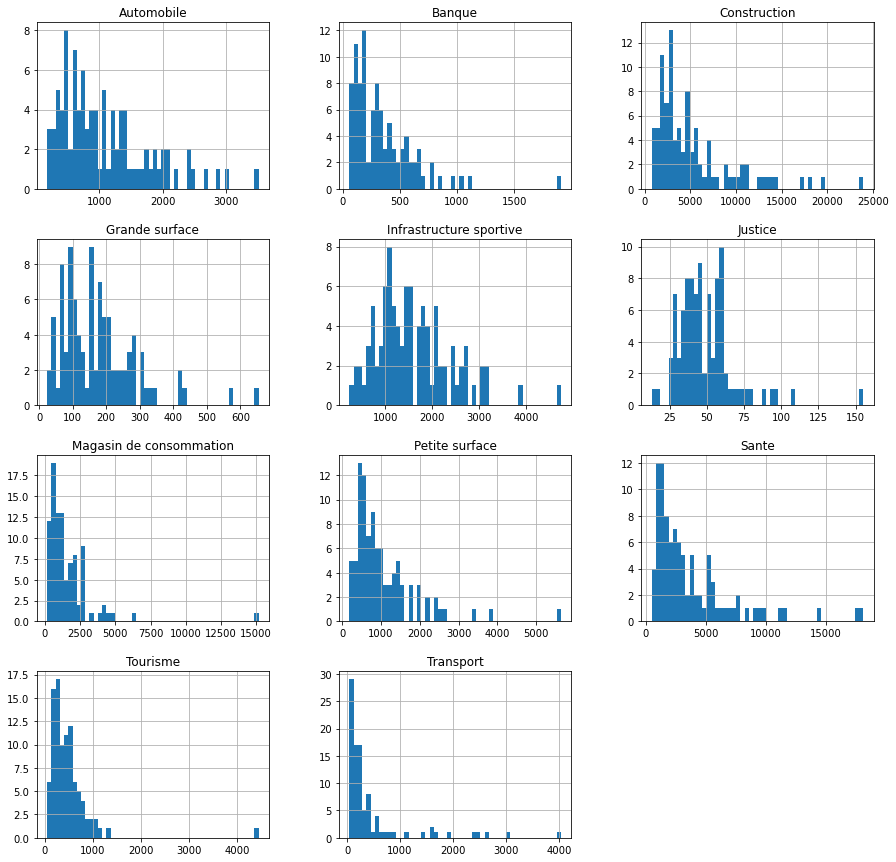

In [64]:
df_equip.drop(columns='DEP').hist(bins=50, figsize=(15,15))
plt.show()

On peut noter que chaque type d'équipement présente un département en décalage en terme d'ordre de grandeur, avec par exemple près de 3000 unités touristiques (offices de tourisme, agence de voyage,...) de plus que les autres départements.

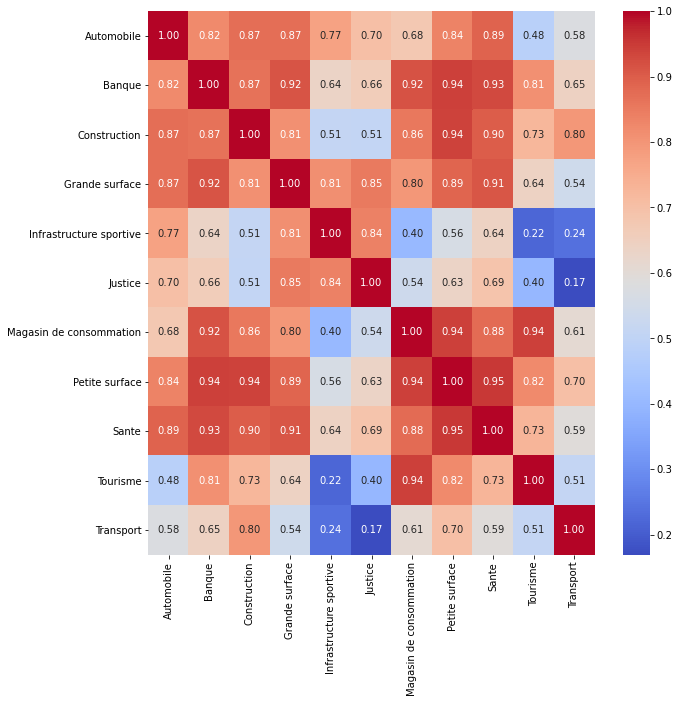

In [65]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_equip.corr(), cmap='coolwarm', annot=True, fmt=".2f")

Quelques corrélations semblent se dessiner comme la taille de la population et la présence de banques et petites épiceries


Regardons s'il existe des disparités entre les départements en prenant l'exemple de la santé

In [66]:
df_pop = pd.read_csv(r'Pop_dep_2013.csv')
df_pop.head()

,DEP,P13_PMEN,NOM
0,01,604986.118319,Ain
1,02,529397.427139,Aisne
2,03,333523.079275,Allier
3,04,158108.410833,Alpes-de-Haute-Provence
4,05,135038.849143,Hautes-Alpes


In [67]:
# Creation d'une base comportant aussi la population  
data = df_equip
data['Population en 2013']=df_pop['P13_PMEN']
data

,DEP,Automobile,Banque,Construction,Grande surface,Infrastructure sportive,Justice,Magasin de consommation,Petite surface,Sante,Tourisme,Transport,Population en 2013
0,01,1216,295,4855,158,2181,57,1089,864,2788,385,276,6.049861e+05
1,02,770,176,3192,161,1928,57,864,693,2297,196,204,5.293974e+05
2,03,591,191,2343,108,1153,45,850,654,1794,258,137,3.335231e+05
3,04,348,97,1977,53,607,35,549,421,1194,329,86,1.581084e+05
4,05,285,98,1523,46,979,27,675,399,1168,415,99,1.350388e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,91,1652,528,9712,262,2067,50,1726,1373,5127,361,1677,1.222904e+06
92,92,1455,852,8859,283,1461,41,2797,1974,7793,939,2498,1.563311e+06
93,93,2058,449,19395,221,1285,17,2625,2564,4917,450,4031,1.521517e+06
94,94,1367,554,10560,228,1503,38,1985,1750,5659,554,2614,1.328778e+06


In [68]:
df_sante =df_equip[['DEP','Sante','Population en 2013']]
df_sante

,DEP,Sante,Population en 2013
0,01,2788,6.049861e+05
1,02,2297,5.293974e+05
2,03,1794,3.335231e+05
3,04,1194,1.581084e+05
4,05,1168,1.350388e+05
...,...,...,...
91,91,5127,1.222904e+06
92,92,7793,1.563311e+06
93,93,4917,1.521517e+06
94,94,5659,1.328778e+06


In [69]:
df_sante['Nom_dpt']=df_dpt['NOM']

<ipython-input-69-94cbecc3c805>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sante['Nom_dpt']=df_dpt['NOM']


In [70]:
df_sante['pop/sante']= df_sante['Population en 2013']/df_sante['Sante']
df_sante

<ipython-input-70-cac2636a2ff6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sante['pop/sante']= df_sante['Population en 2013']/df_sante['Sante']


,DEP,Sante,Population en 2013,Nom_dpt,pop/sante
0,01,2788,6.049861e+05,Ain,216.996456
1,02,2297,5.293974e+05,Aisne,230.473412
2,03,1794,3.335231e+05,Allier,185.910301
3,04,1194,1.581084e+05,Alpes-de-Haute-Provence,132.419105
4,05,1168,1.350388e+05,Hautes-Alpes,115.615453
...,...,...,...,...,...
91,91,5127,1.222904e+06,Essonne,238.522393
92,92,7793,1.563311e+06,Hauts-de-Seine,200.604579
93,93,4917,1.521517e+06,Seine-St-Denis,309.440055
94,94,5659,1.328778e+06,Val-de-Marne,234.807973


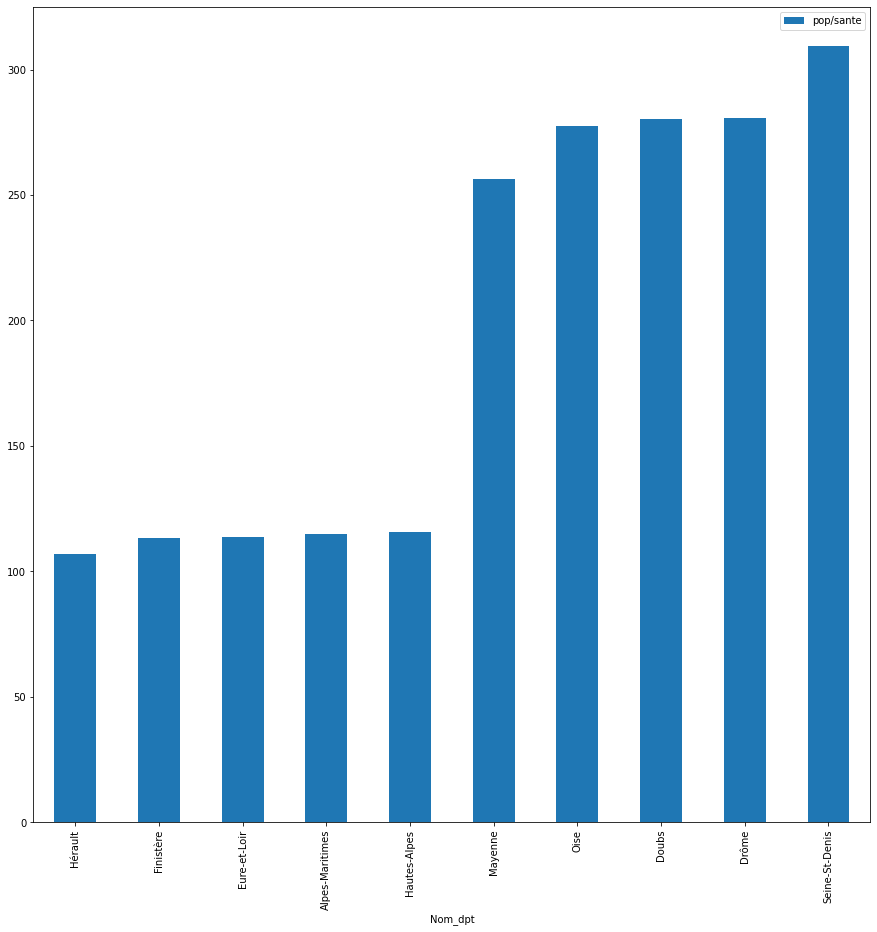

In [71]:
#Représentation des unités de santé par département pondérées à la population
pd.concat([df_sante.sort_values(by='pop/sante').head(5),df_sante.sort_values(by='pop/sante').tail(5)]).plot(x='Nom_dpt', y = 'pop/sante', kind='bar', figsize=(15,15))

On note de grandes disparitées entre les départements : la Seine-St-Denis compte 1 unité de santé pour environ 330 personnes contre seulement 120 personnes dans l'Hérault

# Indicatrices littoral et frontière

La position géographique des départements a une influence sur leur attractivité.  
Nous avons choisi d'intégrer 2 indicatrices à notre modèle, selon si les départements sont situés sur un littoral ou à la frontière d'un pays européen.

In [72]:
# On liste les departments avec littoraux

list_litt = ["59",
            "62",
            "80",
            "76",
            "27",
            "14",
            "50",
            "35",
            "22",
            "29",
            "56",
            "44",
            "85",
            "17",
            "33",
            "40",
            "64",
            "66",
            "11",
            "34",
            "30",
            "13",
            "83",
            "6",
            "2B",
            "2A"]

# Creation d'un dataframe avec tous les departements
df_litt = pd.DataFrame()
df_litt["NUMÉRO"]=df_dpt["NUMÉRO"]

# Creation d'une nouvelle colonne indicatrice
df_litt['Littoral']=0

for i in range(len(df_litt)):
    if df_litt['NUMÉRO'][i] in list_litt:
        df_litt['Littoral'][i] = 1

df_litt.head(10)

<ipython-input-72-21d26edc2a88>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_litt['Littoral'][i] = 1


,NUMÉRO,Littoral
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,1
6,7,0
7,8,0
8,9,0
9,10,0


In [73]:
# On liste les departments avec frontiere

list_front = ["59",
            "2",
            "8",
            "55",
            "54",
            "57",
            "67",
            "68",
            "90",
            "25",
            "39",
            "1",
            "74",
            "73",
            "5",
            "4",
            "6",
            "66",
            "9",
            "31",
            "65",
            "64"]

# Creation d'un dataframe avec tous les departements
df_front = pd.DataFrame()
df_front["NUMÉRO"]=df_dpt["NUMÉRO"]

# Creation d'une nouvelle colonne indicatrice
df_front['Frontiere']=0

for i in range(len(df_front)):
    if df_front['NUMÉRO'][i] in list_front:
        df_front['Frontiere'][i] = 1

df_front.head(10)

<ipython-input-73-6786e02b6ca5>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_front['Frontiere'][i] = 1


,NUMÉRO,Frontiere
0,1,1
1,2,1
2,3,0
3,4,1
4,5,1
5,6,1
6,7,0
7,8,1
8,9,1
9,10,0


In [74]:
# On ajoute ces nouvelles bases à df_equip
df_reg = df_equip
df_reg['Littoral'] = df_litt['Littoral']
df_reg['Frontiere'] = df_front['Frontiere']
df_reg.head()

,DEP,Automobile,Banque,Construction,Grande surface,Infrastructure sportive,Justice,Magasin de consommation,Petite surface,Sante,Tourisme,Transport,Population en 2013,Littoral,Frontiere
0,01,1216,295,4855,158,2181,57,1089,864,2788,385,276,604986.118319,0,1
1,02,770,176,3192,161,1928,57,864,693,2297,196,204,529397.427139,0,1
2,03,591,191,2343,108,1153,45,850,654,1794,258,137,333523.079275,0,0
3,04,348,97,1977,53,607,35,549,421,1194,329,86,158108.410833,0,1
4,05,285,98,1523,46,979,27,675,399,1168,415,99,135038.849143,0,1


# Salaire moyen par département en 2017

In [75]:
df_w = pd.read_excel(r'.\Salaire.xlsx')
df_w

,Num,Departement,Ensemble,Hommes,Femmes,Cadres (y c les chefs d'entreprise salariés),Professions interméd.,Employés,Ouvriers
0,01,Ain,21830,24650,18240,42290,24700,15570,17670
1,02,Aisne,20230,22320,17000,39720,24540,15100,17940
2,03,Allier,19390,21540,16580,38170,23710,14430,17360
3,04,Alpes-de-Haute-Provence,19180,21560,16240,36580,23300,13840,16570
4,05,Hautes-Alpes,17690,19550,15480,33000,21330,13530,16620
...,...,...,...,...,...,...,...,...,...
91,91,Essonne,26490,29100,22980,46540,26650,16960,18060
92,92,Hauts-de-Seine,37120,41650,31840,56770,27570,17400,17430
93,93,Seine-Saint-Denis,20640,21550,19310,38720,24310,15430,16180
94,94,Val-de-Marne,26770,28940,24020,46280,25920,16630,17470


In [76]:
df_reg['Salaire Moyen']=df_w['Ensemble']
df_reg.head()

,DEP,Automobile,Banque,Construction,Grande surface,Infrastructure sportive,Justice,Magasin de consommation,Petite surface,Sante,Tourisme,Transport,Population en 2013,Littoral,Frontiere,Salaire Moyen
0,01,1216,295,4855,158,2181,57,1089,864,2788,385,276,604986.118319,0,1,21830
1,02,770,176,3192,161,1928,57,864,693,2297,196,204,529397.427139,0,1,20230
2,03,591,191,2343,108,1153,45,850,654,1794,258,137,333523.079275,0,0,19390
3,04,348,97,1977,53,607,35,549,421,1194,329,86,158108.410833,0,1,19180
4,05,285,98,1523,46,979,27,675,399,1168,415,99,135038.849143,0,1,17690


# Taux de chômage moyen

In [77]:
df_cho = pd.read_csv(r'.\chomage_dep.csv',sep=';')
df_cho

,Code,Libellé,T1_1982,T2_1982,T3_1982,T4_1982,T1_1983,T2_1983,T3_1983,T4_1983,...,T1_2019,T2_2019,T3_2019,T4_2019,T1_2020,T2_2020,T3_2020,T4_2020,T1_2021,T2_2021
0,1,AIN,"3,8","3,9",4,"4,1","4,2","4,2","4,4","4,6",...,"6,2",6,"6,2","5,9","5,7","5,6",7,6,"6,1","5,9"
1,2,AISNE,"8,3","8,5","8,6","8,5","8,5","8,6","8,8","9,2",...,"12,1","11,8","11,9","11,4","11,2","9,7","12,6",11,"11,2",11
2,3,ALLIER,"7,4","7,6","7,8","7,8","7,8","7,8","7,9","8,5",...,"9,3","9,1","9,1","8,7","8,5",8,"9,8","8,3","8,4","8,5"
3,4,ALPES-DE-HAUTE-PROVENCE,"5,6","5,7","5,9","6,1","6,2","6,2","6,4","6,7",...,"10,5","10,2","10,2","9,5","9,2","8,8","10,6",9,"9,4","9,5"
4,5,HAUTES-ALPES,"4,9",5,"5,1","5,4","5,8","5,9","6,1","6,5",...,"8,2","7,9","7,9","7,6","7,3","6,9","8,4","7,5","9,2","7,8"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,VAL-D'OISE,"5,4","5,4","5,6","5,5","5,6","5,6","5,6","5,9",...,"8,9","8,6","8,7","8,4","8,1","7,3","9,8",9,"8,9","8,8"
96,971,GUADELOUPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"20,9",19,"20,2","20,4","18,2","10,9","18,9","19,4","17,6","19,3"
97,972,MARTINIQUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"17,3","15,7","15,1","16,5","12,3","8,5","16,4",15,"12,8",15
98,973,GUYANE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"15,5","17,4","18,3","17,3","14,5","7,1","17,1","17,8","12,7",14


In [78]:
# On retire les Outre-Mers
for dpt in [971,972,973,974,976]:
    df_cho = df_cho.drop(df_cho.index[df_cho['Code'] == str(dpt)])
    
#On selectionne les variables intéressantes
df_cho = df_cho[['Code','Libellé','T1_2016']]
df_cho

,Code,Libellé,T1_2016
0,1,AIN,"7,4"
1,2,AISNE,"13,9"
2,3,ALLIER,"10,8"
3,4,ALPES-DE-HAUTE-PROVENCE,"11,6"
4,5,HAUTES-ALPES,"9,4"
...,...,...,...
91,91,ESSONNE,"7,8"
92,92,HAUTS-DE-SEINE,"7,7"
93,93,SEINE-SAINT-DENIS,"12,9"
94,94,VAL-DE-MARNE,"8,9"


In [79]:
# Ajout à notre DataFrame de regresseurs
df_reg['Chômage moyen T1_2016']=df_cho['T1_2016']
df_reg.head()

,DEP,Automobile,Banque,Construction,Grande surface,Infrastructure sportive,Justice,Magasin de consommation,Petite surface,Sante,Tourisme,Transport,Population en 2013,Littoral,Frontiere,Salaire Moyen,Chômage moyen T1_2016
0,01,1216,295,4855,158,2181,57,1089,864,2788,385,276,604986.118319,0,1,21830,"7,4"
1,02,770,176,3192,161,1928,57,864,693,2297,196,204,529397.427139,0,1,20230,"13,9"
2,03,591,191,2343,108,1153,45,850,654,1794,258,137,333523.079275,0,0,19390,"10,8"
3,04,348,97,1977,53,607,35,549,421,1194,329,86,158108.410833,0,1,19180,"11,6"
4,05,285,98,1523,46,979,27,675,399,1168,415,99,135038.849143,0,1,17690,"9,4"


In [80]:
# Attention les données du chômage sont des chaînes de caractère, on les transforme d'abord en flottant
import locale
locale.setlocale(locale.LC_ALL, 'nl_NL')
for i in range (len(df_reg)):
    df_reg['Chômage moyen T1_2016'][i]=locale.atof(df_reg['Chômage moyen T1_2016'][i])

<ipython-input-80-c2a250abcbc3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['Chômage moyen T1_2016'][i]=locale.atof(df_reg['Chômage moyen T1_2016'][i])


In [81]:
df_reg.to_csv(r'.\base_regresseurs.csv')